In [59]:
import matplotlib.pyplot as plt
%matplotlib inline

IMAGES_DIR = "/mnt/spin6TB/dirkgr/images"
MAX_IMAGE_SIZE = (500, 500)
BORDER = 6 # has to be even
INPUT_SIZE = ((MAX_IMAGE_SIZE[0] + BORDER) / 2, (MAX_IMAGE_SIZE[1] + BORDER) / 2)

In [60]:
import os
def allImageFilenames(directory):
    for root, dirs, files in os.walk(directory):
        for f in files:
            if f.endswith(".jpg"):
                yield os.path.join(root, f)

import skimage.io
def allRawImages(filenames):
    for filename in filenames:
        image = skimage.io.imread(filename)
        if image.shape[0] > MAX_IMAGE_SIZE[0]:
            raise ValueError("Image %s too big: %r" % (filename, image.shape))
        if image.shape[1] > MAX_IMAGE_SIZE[1]:
            raise ValueError("Image %s too big: %r" % (filename, image.shape))
        yield image
        
import skimage.util
def padImage(image):
    widthFactor = (MAX_IMAGE_SIZE[0] - image.shape[0]) / 2
    heightFactor = (MAX_IMAGE_SIZE[1] - image.shape[1]) / 2
    padValues = (
        (widthFactor, widthFactor + widthFactor % 2),
        (heightFactor, heightFactor + heightFactor % 2),
        (0, 0)
    )
    return skimage.util.pad(image, padValues, 'constant', constant_values=0)

def scaleDown(image):
    return skimage.transform.rescale(image, 0.5)

def floatImage(image):
    return skimage.util.img_as_float(image)

import numpy
def axisFormatToKeras(image):
    return numpy.moveaxis(image, 2, 0)
def axisFormatFromKeras(image):
    return numpy.moveaxis(image, 0, 2)

filenames = list(allImageFilenames(IMAGES_DIR))
TRAINING_FRACTION = 0.7
cutoff = int(len(filenames) * TRAINING_FRACTION)
filenames_train = filenames[:cutoff]
filenames_test = filenames[:cutoff]

def makeData(filenames):
    for rawImage in allRawImages(filenames):
        padded = floatImage(padImage(rawImage))
        yield map(axisFormatToKeras, (scaleDown(padded), padded))
        
train = makeData(filenames_train)
test = makeData(filenames_test)

In [62]:
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.convolutional import Convolution2D, UpSampling2D

model = Sequential()
model.add(Convolution2D(32, 5, 5, activation="relu", border_mode='same', input_shape = (3,) + INPUT_SIZE))
model.add(Convolution2D(32, 5, 5, activation="relu", border_mode='same'))
model.add(Convolution2D(32, 5, 5, activation="relu", border_mode='same'))
model.add(UpSampling2D())
model.add(Convolution2D(32, 5, 5, activation="relu", border_mode='same'))
model.add(Convolution2D(16, 5, 5, activation="relu", border_mode='same'))
model.add(Convolution2D(3, 5, 5, activation="relu", border_mode='same'))
model.summary()
model.compile(loss='mse', optimizer='sgd', metrics=['accuracy'])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_37 (Convolution2D) (None, 32, 253, 253)  2432        convolution2d_input_14[0][0]     
____________________________________________________________________________________________________
convolution2d_38 (Convolution2D) (None, 32, 253, 253)  25632       convolution2d_37[0][0]           
____________________________________________________________________________________________________
convolution2d_39 (Convolution2D) (None, 32, 253, 253)  25632       convolution2d_38[0][0]           
____________________________________________________________________________________________________
upsampling2d_6 (UpSampling2D)    (None, 32, 506, 506)  0           convolution2d_39[0][0]           
___________________________________________________________________________________________

In [63]:
model.fit_generator(train, samples_per_epoch = 1024, nb_epoch=16)
score = model.evaluate_generator(test)

Exception: Error when checking model input: data should be a Numpy array, or list/dict of Numpy arrays. Found: <generator object X at 0x7f73520de460>...

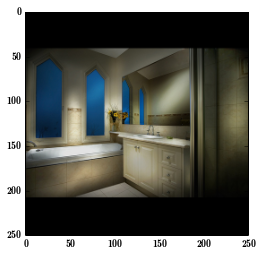

In [33]:
plt.imshow(scaledImage)
#plt.imshow(paddedImage)